In [ ]:
import pandas as pd

# Load CSV files instead of Excel
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")


In [ ]:
print(train.head())
print(features.head())
print(stores.head())

print(train.isnull().sum())
print(features.isnull().sum())
print(stores.isnull().sum())


   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211

In [ ]:
features.fillna(method='ffill', inplace=True)  # Or use mean/median imputation


<ipython-input-10-0e045a46ded1>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features.fillna(method='ffill', inplace=True)  # Or use mean/median imputation


In [ ]:
# Merge train set
train_merged = train.merge(stores, on='Store') \
                    .merge(features, on=['Store', 'Date', 'IsHoliday'])

# Merge test set (for future predictions)
test_merged = test.merge(stores, on='Store') \
                  .merge(features, on=['Store', 'Date', 'IsHoliday'])


In [ ]:
train_merged['Date'] = pd.to_datetime(train_merged['Date'])
train_merged['Year'] = train_merged['Date'].dt.year
train_merged['Month'] = train_merged['Date'].dt.month
train_merged['Week'] = train_merged['Date'].dt.isocalendar().week
train_merged['DayOfWeek'] = train_merged['Date'].dt.dayofweek
train_merged['IsWeekend'] = train_merged['DayOfWeek'].isin([5,6]).astype(int)


In [ ]:
train_merged['Type'] = train_merged['Type'].map({'A': 0, 'B': 1, 'C': 2})


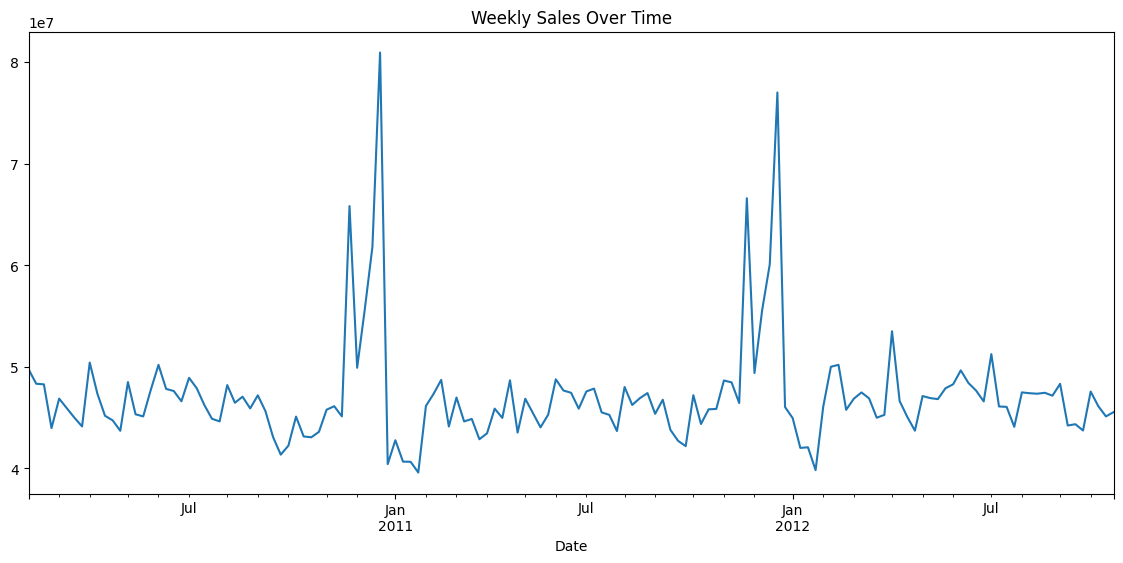

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sales trend over time
total_sales = train_merged.groupby('Date')['Weekly_Sales'].sum()
total_sales.plot(title='Weekly Sales Over Time', figsize=(14,6))
plt.show()


In [ ]:
store_1 = train_merged[train_merged['Store'] == 1]
store_sales = store_1.groupby('Date')['Weekly_Sales'].sum().asfreq('W').fillna(method='ffill')

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(store_sales, order=(1,1,1), seasonal_order=(1,1,1,52))
results = model.fit()

forecast = results.forecast(steps=30)


<ipython-input-15-e7237e356472>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  store_sales = store_1.groupby('Date')['Weekly_Sales'].sum().asfreq('W').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

X = train_merged.drop(['Weekly_Sales', 'Date'], axis=1)
y = train_merged['Weekly_Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"MAE: {mae}, RMSE: {rmse}")


MAE: 6028.402188968063, RMSE: 10285.120688433208


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure your Date column is in datetime format
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

# Merge everything
merged = train.merge(stores, on='Store') \
              .merge(features, on=['Store', 'Date', 'IsHoliday'])

# Add more date features
merged['Year'] = merged['Date'].dt.year
merged['Month'] = merged['Date'].dt.month
merged['Week'] = merged['Date'].dt.isocalendar().week
merged['DayOfWeek'] = merged['Date'].dt.dayofweek


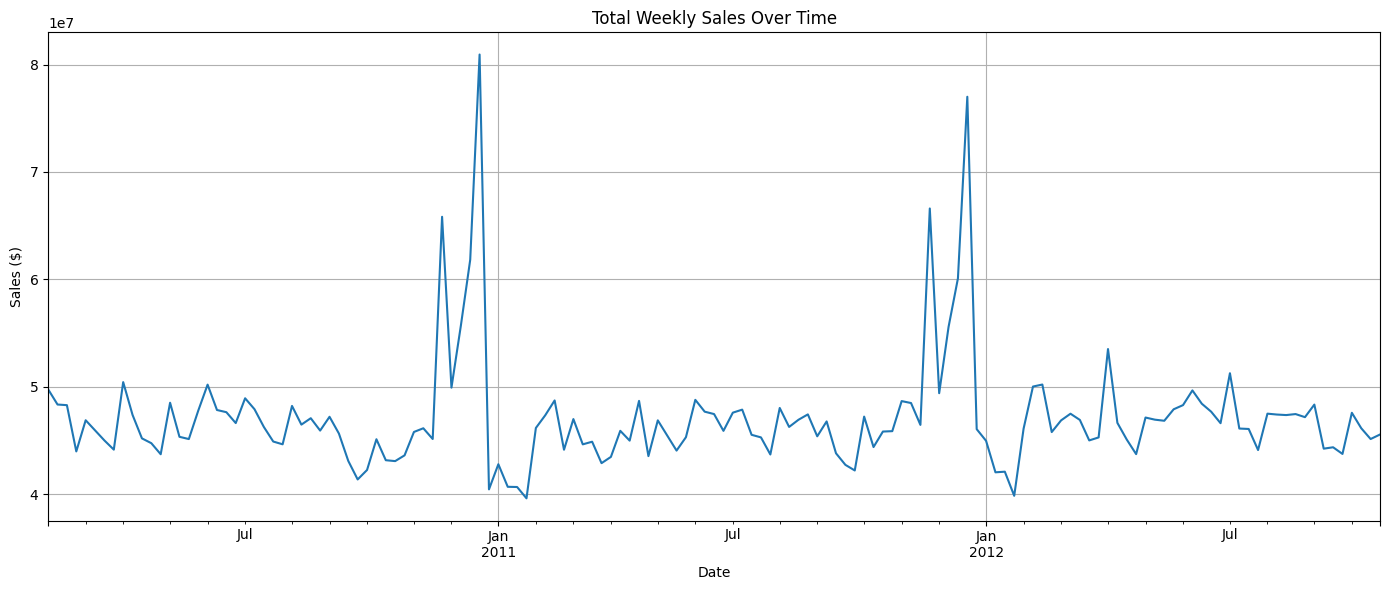

In [ ]:
plt.figure(figsize=(14,6))
merged.groupby('Date')['Weekly_Sales'].sum().plot()
plt.title("Total Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-20-29a047f23fee>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=store_sales.index, y=store_sales.values, palette="viridis")


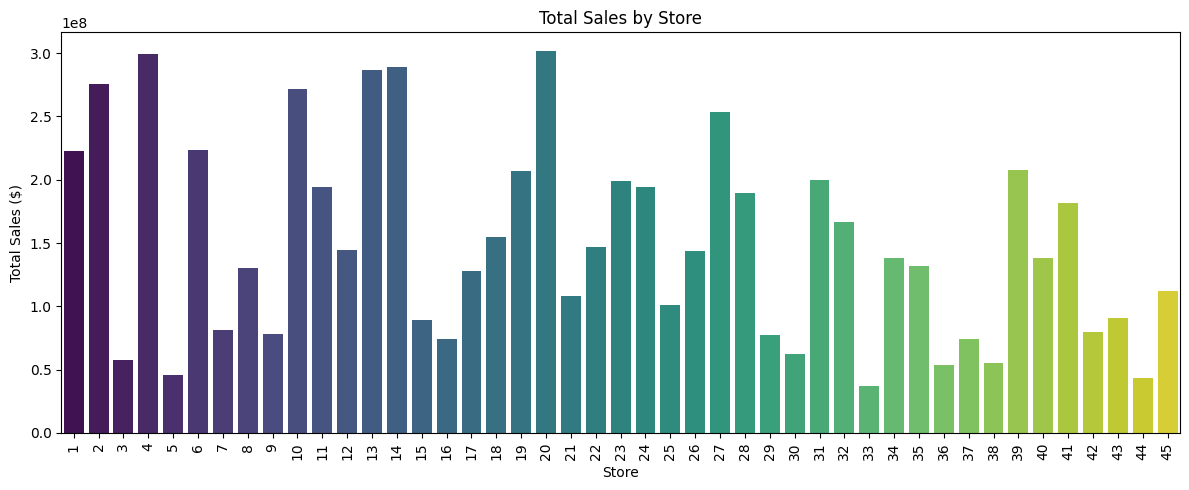

In [ ]:
plt.figure(figsize=(12,5))
store_sales = merged.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)
sns.barplot(x=store_sales.index, y=store_sales.values, palette="viridis")
plt.title("Total Sales by Store")
plt.xlabel("Store")
plt.ylabel("Total Sales ($)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


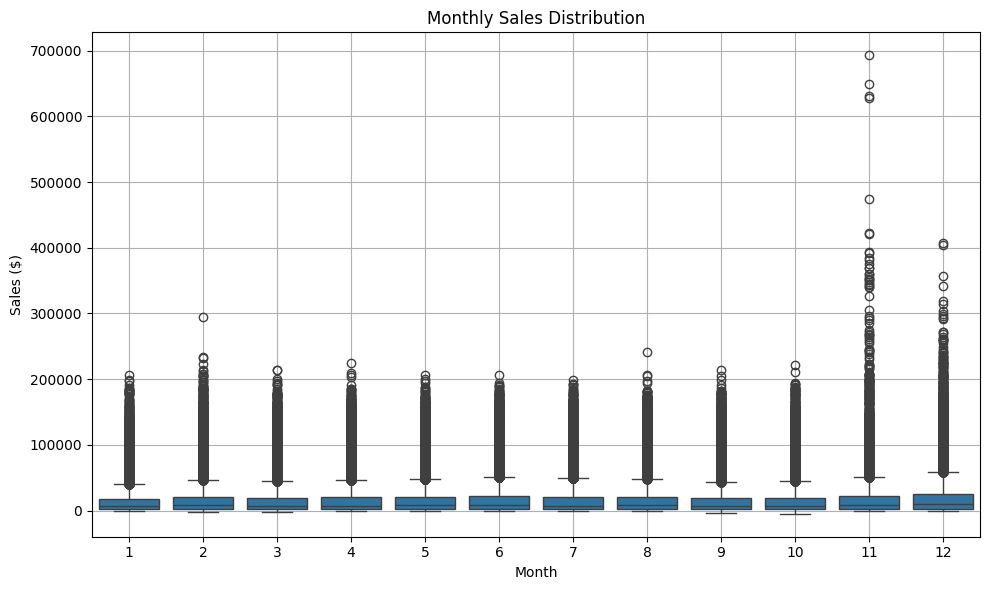

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Month', y='Weekly_Sales', data=merged)
plt.title("Monthly Sales Distribution")
plt.xlabel("Month")
plt.ylabel("Sales ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


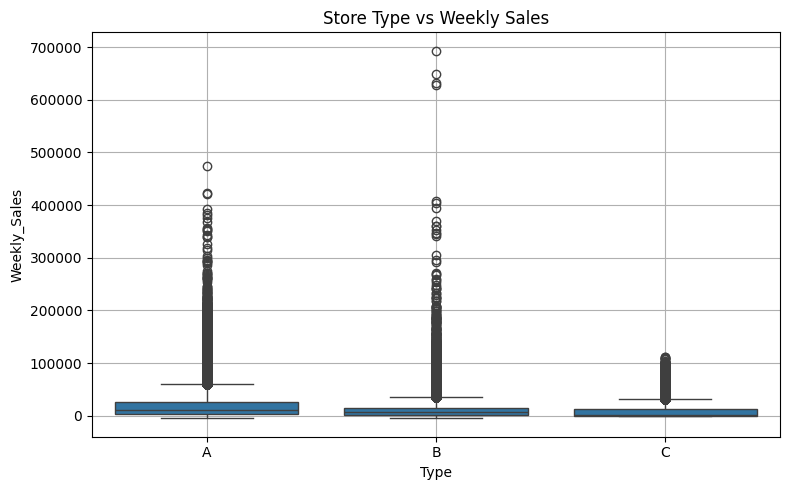

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Type', y='Weekly_Sales', data=merged)
plt.title("Store Type vs Weekly Sales")
plt.grid(True)
plt.tight_layout()
plt.show()


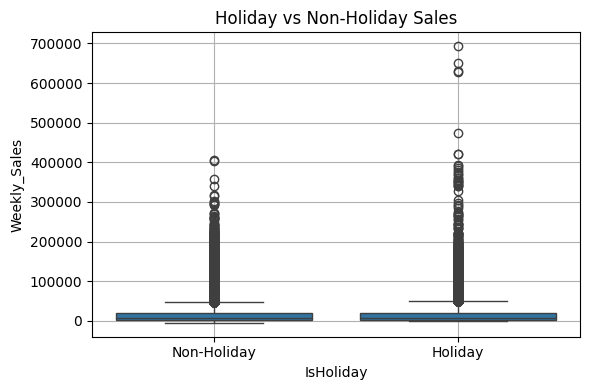

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=merged)
plt.title("Holiday vs Non-Holiday Sales")
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.grid(True)
plt.tight_layout()
plt.show()


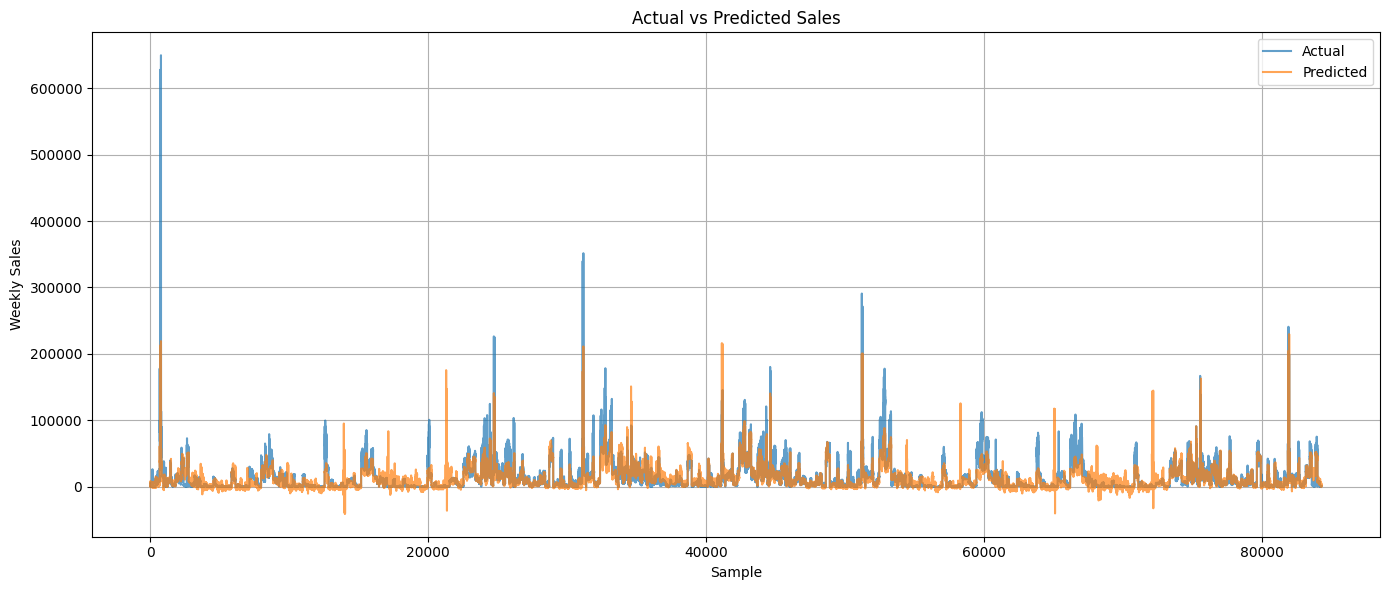

In [ ]:
import numpy as np

# Assume you have: y_val (true values) and y_pred (model predictions)
plt.figure(figsize=(14,6))
plt.plot(np.arange(len(y_val)), y_val, label="Actual", alpha=0.7)
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted", alpha=0.7)
plt.title("Actual vs Predicted Sales")
plt.xlabel("Sample")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.8 MB/s eta 0:00:00


<ipython-input-26-3851c69c1542>:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


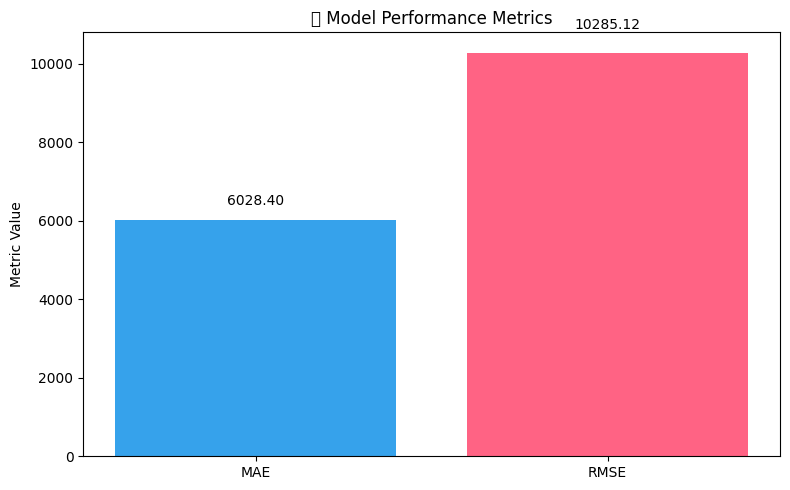

In [ ]:
import matplotlib.pyplot as plt

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

# Visualization
metrics = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
names = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(8,5))
bars = plt.bar(names, values, color=['#36a2eb', '#ff6384', '#ffcd56'])
plt.title("📊 Model Performance Metrics")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05*yval, f'{yval:.2f}', ha='center', va='bottom')
plt.ylabel("Metric Value")
plt.tight_layout()
plt.show()
